In [6]:
from ptp.models.gan_3d.gan3d import Generator

ModuleNotFoundError: No module named 'src'

In [5]:
import nibabel as nib

In [1]:
from src.ptp.models.gan_3d.gan3d import Generator
from src.ptp.models.gan_3d.discriminator import Discriminator
from src.ptp.models.gan_3d.gan3d import GAN3D
from src.ptp.models.gan_3d.building_blocks import ResNetBlock3d, InvertedResidual3d
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib  
import numpy as np
import wandb
from lightning.pytorch.loggers import WandbLogger

from monai.data import MetaTensor
import pytorch_lightning as pl
import torch
from monai.transforms import (
    NormalizeIntensityd
)
from torch import nn
import os

ModuleNotFoundError: No module named 'src'

In [7]:
wandb_logger = WandbLogger(project="GAN3D-PTP")

In [8]:
wandb.login(key='')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
DATA_DIR = Path('/kaggle/input/ptp-one-sample')
TARGET_DATA_DIR = DATA_DIR
INPUT_DIR = Path('/kaggle/working')
MODELS_DIR = INPUT_DIR / 'models'
TRAINING_DIR = INPUT_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [11]:
discriminator = Discriminator(1)

In [12]:
sum(p.numel() for p in discriminator.parameters() if p.requires_grad)

410096

In [13]:
input_pt = torch.rand((10, 1, 256, 256, 256))

In [14]:
discriminator(input_pt).shape

torch.Size([10, 1])

In [ ]:
sample_tensor = torch.randn((1, 3, 10, 10, 10))

In [ ]:
inv_residual = InvertedResidual3d(3, oup=3, stride=2, expand_ratio=0.5)
output = inv_residual(sample_tensor)

In [ ]:
output.shape

In [ ]:
resnet_block = ResNetBlock3d(3, nn.ReLU)

In [ ]:
resnet_input = torch.randn((1, 3, 10, 10, 10))
resnet_result = resnet_block(resnet_input)

In [ ]:
resnet_result.shape

In [ ]:
t1 = torch.randn((1, 3, 10, 10, 10))
t2 = torch.randn((1, 3, 10, 10, 10))

torch.cat([t1, t2], axis=1).shape

In [ ]:
gen = Generator()

In [ ]:
t1 = torch.randn((1, 1, 256, 256, 256))

In [ ]:
output = gen(t1)

In [ ]:
output.shape

In [ ]:
output[0, 0, 0, ...].detach().numpy()

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(output[0, 0, 0, ...].detach().numpy())

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(output[0, 0, :, 100, :].detach().numpy())

In [ ]:
output.mean()

In [ ]:
normalized_tf = NormalizeIntensityd(keys=['target'])

target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file).get_fdata()

target = MetaTensor(torch.unsqueeze(torch.Tensor(target), 0))
print(target.shape)

data = normalized_tf({'target': target})

In [ ]:
target.numpy()[0, 0, 0, :20]

In [ ]:
data['target'].as_tensor().numpy()[0, 0, 0, :20]

In [ ]:
visualize_slices(nib.Nifti1Image(target.numpy()[0], np.eye(4)), 50, 150, 400, f'Target {target_file.split(".")[-2]}')
visualize_slices(nib.Nifti1Image(data['target'].as_tensor().numpy()[0], np.eye(4)), 50, 150, 400, f'Normalized {target_file.split(".")[-2]}')

In [44]:
percentile = 5
n_critic = 3

In [45]:
gan = GAN3D(percentile=percentile, n_critic=n_critic, target_data_dir=TARGET_DATA_DIR)

In [46]:
gen_params = sum(p.numel() for p in gan.G.parameters() if p.requires_grad)
d_params = sum(p.numel() for p in gan.D.parameters() if p.requires_grad)
print(gen_params)
print(d_params)

571747
410096


In [ ]:
max_epochs = 40

checkpoint_dir = Path('/kaggle/working/gan-test-1')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    logger=wandb_logger
)

trainer.fit(gan)

In [48]:
MODEL_PATH = Path('/kaggle/working/gan-test-1/gan-40')

In [50]:
torch.save(gan.state_dict(), MODEL_PATH)

In [51]:
gan_2 = GAN3D(percentile=percentile, n_critic=n_critic, target_data_dir=TARGET_DATA_DIR)
gan_2.load_state_dict(torch.load(MODEL_PATH))
gan_2.eval()

GAN3D(
  (G): Generator(
    (down1): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (down2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (inv_res_h_1): InvertedResidual3d(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): ConvBNReLU(
          (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
   

In [52]:
gan_2.prepare_data()
gan_2.to('cpu')
train_loader = gan_2.train_dataloader()

Gan trenowany na 1 próbce

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


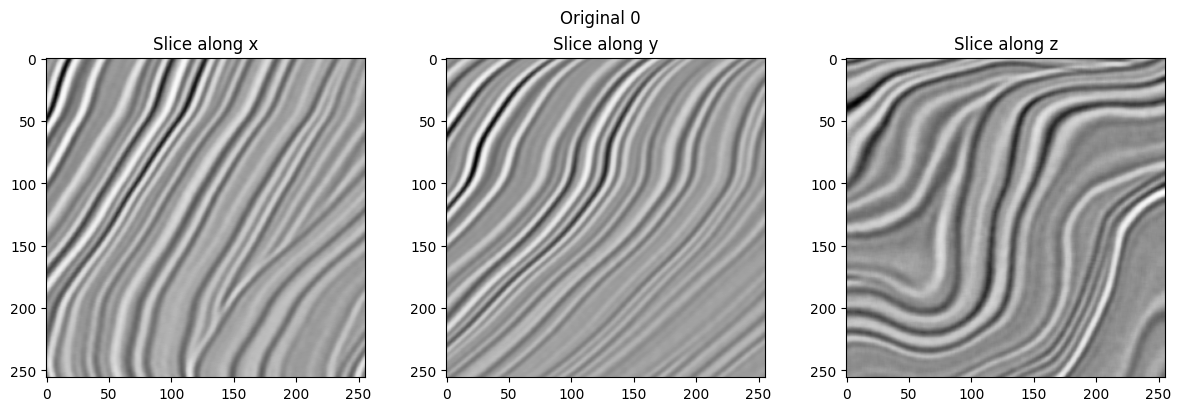

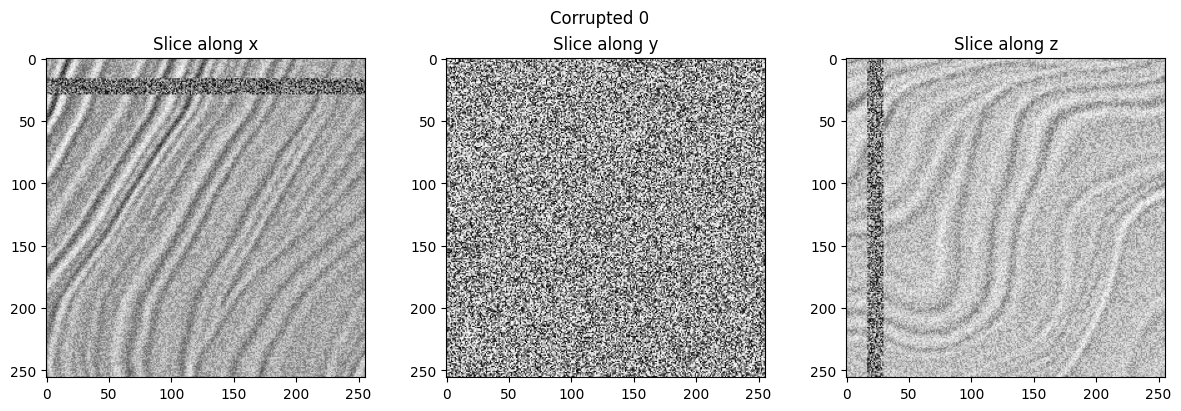

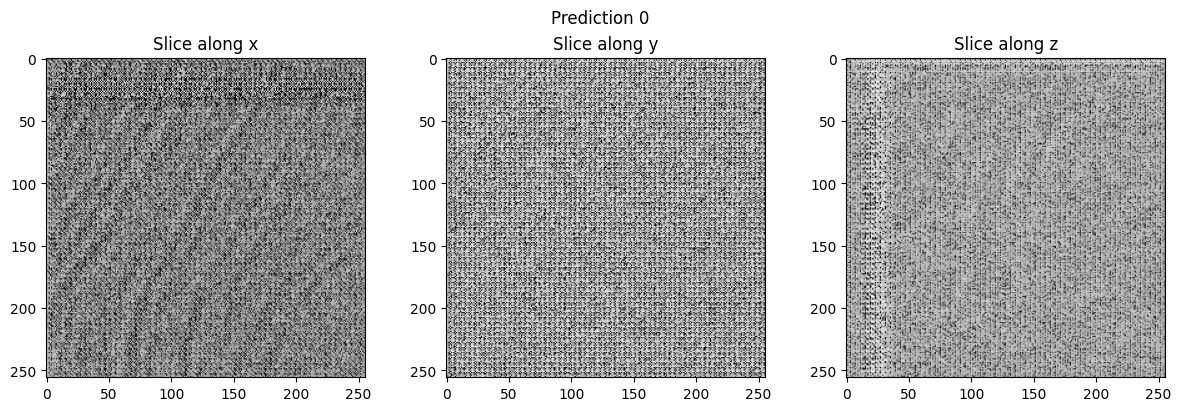

In [53]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(train_loader):
    prediction = gan_2(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)